# Novelty and Outlier Detection
- ### https://scikit-learn.org/stable/modules/outlier_detection.html

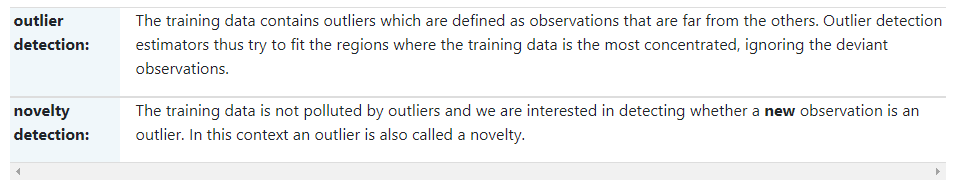

# 1. Overview of outlier detection methods

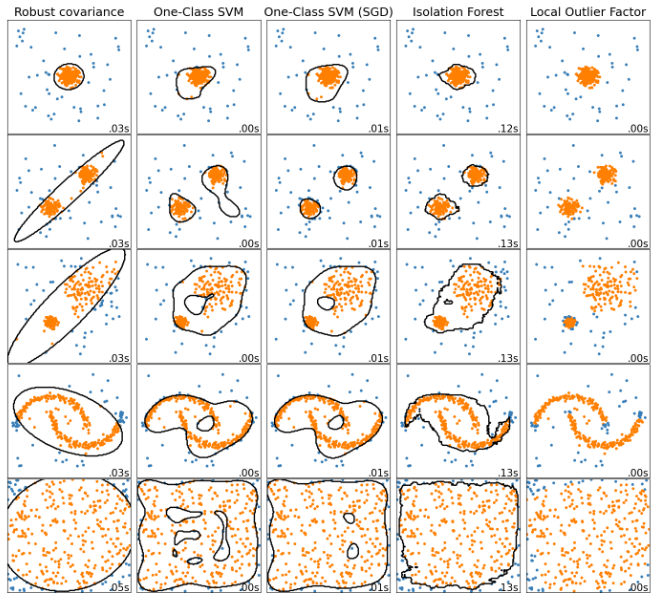

# 3.Outlier Detection

## 3.1 Fitting an elliptic envelope
- Outlier detection을 수행하기 위해서, 우리 데이터를 Gaussian ditribution로 가정함.
- 이러한 기준에서 벗어나는 데이터를 (far enough from the fit shape) outlier로 지정.
- Gaussian distributed data는 관측된 x값에 대한 거리를 Mahalanobis distance로 나타내어 Covariance estimation을 할 수 있다.
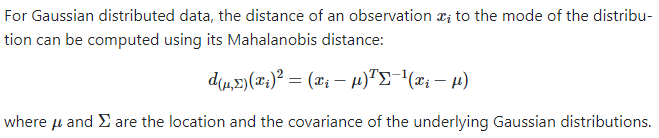
- 여기서 분포를 추정하기 위한 Maximum likelihood estimate(MLE)는 outlier에 very senstive하기 때문에 erroneous observation에 resistant한 robust estimator of covariance가 필요함
- Minimum Covariance Determinant estimator (MCD)가 robust 하다. 아래 예제에서는 그 차이를 보여줌
- https://scikit-learn.org/stable/modules/generated/sklearn.covariance.MinCovDet.html

In [16]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet

#### Data 생성

In [6]:
import numpy as np

# for consistent results
np.random.seed(7)

n_samples = 125
n_outliers = 25
n_features = 2

# generate Gaussian data of shape (125, 2)
gen_cov = np.eye(n_features)
gen_cov[0, 0] = 2.0
X = np.dot(np.random.randn(n_samples, n_features), gen_cov)

# add some outliers
outliers_cov = np.eye(n_features)
outliers_cov[np.arange(1, n_features), np.arange(1, n_features)] = 7.0
X[-n_outliers:] = np.dot(np.random.randn(n_outliers, n_features), outliers_cov)

#### 결과 비교 - MCD 기반 Robust estimator가 MLE보다 outlier sample에 더 내성을 보임

In [10]:
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance, MinCovDet

# fit a MCD robust estimator to data
robust_cov = MinCovDet().fit(X)
# fit a MLE estimator to data
emp_cov = EmpiricalCovariance().fit(X)
print(
    "Estimated covariance matrix:\nMCD (Robust):\n{}\nMLE:\n{}".format(
        robust_cov.covariance_, emp_cov.covariance_
    )
)

Estimated covariance matrix:
MCD (Robust):
[[ 3.26253567e+00 -3.06695631e-03]
 [-3.06695631e-03  1.22747343e+00]]
MLE:
[[ 3.23773583 -0.24640578]
 [-0.24640578  7.51963999]]


#### Mahalanobis distances of a contaminated data set

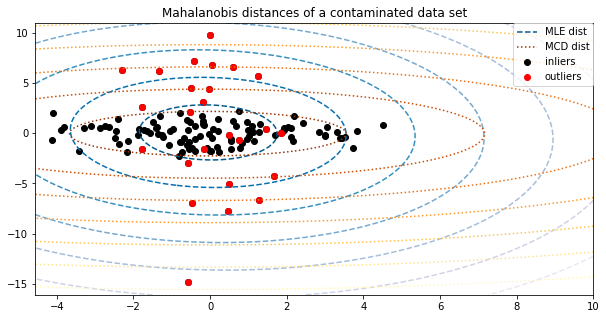

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot data set
inlier_plot = ax.scatter(X[:, 0], X[:, 1], color="black", label="inliers")
outlier_plot = ax.scatter(
    X[:, 0][-n_outliers:], X[:, 1][-n_outliers:], color="red", label="outliers"
)
ax.set_xlim(ax.get_xlim()[0], 10.0)
ax.set_title("Mahalanobis distances of a contaminated data set")

# Create meshgrid of feature 1 and feature 2 values
xx, yy = np.meshgrid(
    np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
    np.linspace(plt.ylim()[0], plt.ylim()[1], 100),
)
zz = np.c_[xx.ravel(), yy.ravel()]

# Calculate the MLE based Mahalanobis distances of the meshgrid
mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = plt.contour(
    xx, yy, np.sqrt(mahal_emp_cov), cmap=plt.cm.PuBu_r, linestyles="dashed"
)
# Calculate the MCD based Mahalanobis distances
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = ax.contour(
    xx, yy, np.sqrt(mahal_robust_cov), cmap=plt.cm.YlOrBr_r, linestyles="dotted"
)

# Add legend
ax.legend(
    [
        emp_cov_contour.collections[1],
        robust_contour.collections[1],
        inlier_plot,
        outlier_plot,
    ],
    ["MLE dist", "MCD dist", "inliers", "outliers"],
    loc="upper right",
    borderaxespad=0,
)

plt.show()

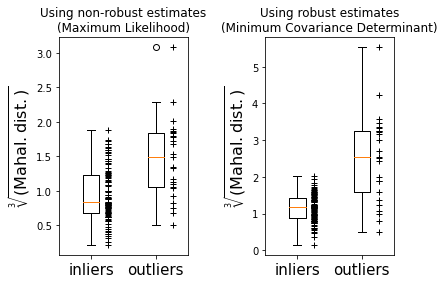

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.6)

# Calculate cubic root of MLE Mahalanobis distances for samples
emp_mahal = emp_cov.mahalanobis(X - np.mean(X, 0)) ** (0.33)
# Plot boxplots
ax1.boxplot([emp_mahal[:-n_outliers], emp_mahal[-n_outliers:]], widths=0.25)
# Plot individual samples
ax1.plot(
    np.full(n_samples - n_outliers, 1.26),
    emp_mahal[:-n_outliers],
    "+k",
    markeredgewidth=1,
)
ax1.plot(np.full(n_outliers, 2.26), emp_mahal[-n_outliers:], "+k", markeredgewidth=1)
ax1.axes.set_xticklabels(("inliers", "outliers"), size=15)
ax1.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
ax1.set_title("Using non-robust estimates\n(Maximum Likelihood)")

# Calculate cubic root of MCD Mahalanobis distances for samples
robust_mahal = robust_cov.mahalanobis(X - robust_cov.location_) ** (0.33)
# Plot boxplots
ax2.boxplot([robust_mahal[:-n_outliers], robust_mahal[-n_outliers:]], widths=0.25)
# Plot individual samples
ax2.plot(
    np.full(n_samples - n_outliers, 1.26),
    robust_mahal[:-n_outliers],
    "+k",
    markeredgewidth=1,
)
ax2.plot(np.full(n_outliers, 2.26), robust_mahal[-n_outliers:], "+k", markeredgewidth=1)
ax2.axes.set_xticklabels(("inliers", "outliers"), size=15)
ax2.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
ax2.set_title("Using robust estimates\n(Minimum Covariance Determinant)")

plt.show()

# 3.2 Isolation Forest

- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
- <b>매우 높은 차원의 데이터 셋에서도 잘 작동한다!</b>
- One efficient way of performing outlier detection in high-dimensional datasets is to use <b>Random forests</b>.
- The ensemble.IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.
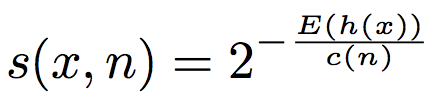
- h(x)는 관측치 x의 경로 길이이고, c(n)은 이진 검색 트리에서 실패한 검색의 평균 경로 길이, n은 외부 노드의 수를 말한다. 
- 각 관찰 포인트에는 이상값에 대한 점수가 주어지며 그에 따라 다음과 같은 결정을 내릴 수 있다.
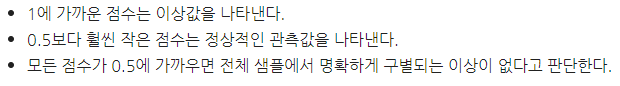

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [26]:
rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]

# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]

# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

In [22]:
# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

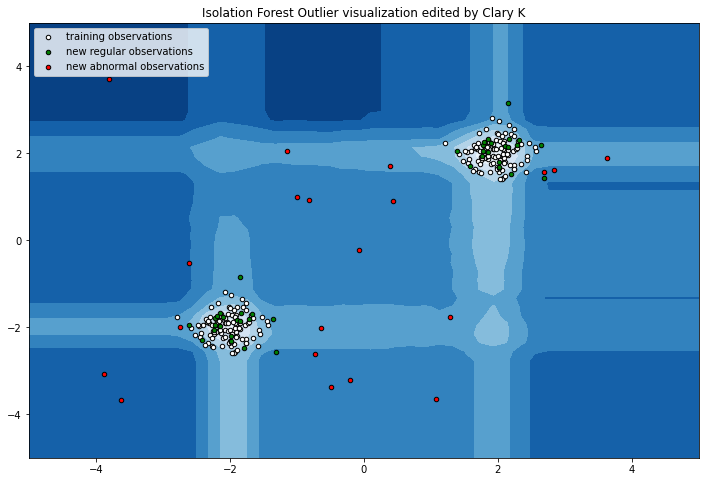

In [28]:
# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12,8))
plt.title("Isolation Forest Outlier visualization edited by Clary K")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=20, edgecolor="k")
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="green", s=20, edgecolor="k")
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="red", s=20, edgecolor="k")
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend(
    [b1, b2, c],
    ["training observations", "new regular observations", "new abnormal observations"],
    loc="upper left",
)
plt.show()

# 3.3 Local Outlier Factor (LOF)

- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html
- 적당히 높은 차원의 데이터 세트에서 이상값 검색 수행
- The neighbors.LocalOutlierFactor (LOF) algorithm is unspervised anomaly detection method which computes the local density deciation of a given data point with respect to its neighbors.
- It considers as outliers the samples that have a substantially lower density than their neighbors.
- locality is given by <b>k-nearest neighbors</b>, whose distance is used to estimate the local density.
- Note that when LOF is used for outlier detection it has no predict, decision_function and score_samples but only have a <b>fit_predict</b> method.
- <b>metric: default=’minkowski’</b>; 이거쓰려면 다른걸로 바꿔라

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

In [32]:
np.random.seed(42)

# Generate train data
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

# Generate some outliers
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

In [33]:
# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

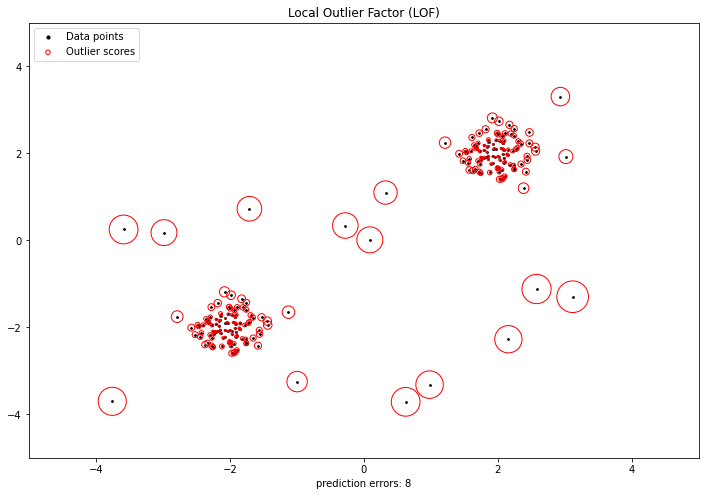

In [34]:
# use fit_predict to compute the predicted labels of the training samples - fit은 Novelty확인
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

plt.figure(figsize=(12,8))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

# 3.4 Novelty detection with Local Outlier Factor

- To use neighbors.LocalOutlierFactor for novelty detection, (predict labels or compute the score of abnormality of new unseen data) you need to instantiate the estimator with the <b>novelty parameter set to True</b>

In [35]:
lof = LocalOutlierFactor(novelty=True)
lof.fit(X_train)

LocalOutlierFactor(novelty=True)

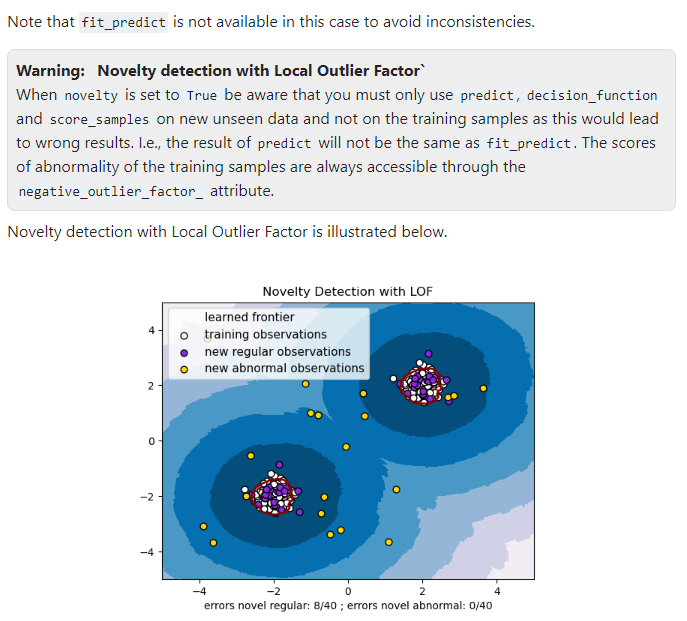

# Outlier detection on a real data set

- https://scikit-learn.org/stable/auto_examples/applications/plot_outlier_detection_wine.html?highlight=outlier